# NCP, Fe uptake, lims,Fe timeseries from the CESM-LE

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import os
from glob import glob
#from collections import OrderedDict
import xarray as xr
import numpy as np
#import dask
#from ncar_jobqueue import NCARCluster
import esmlab
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
from scipy import stats
import pop_tools 

from statistics import mean
from matplotlib import style
from scipy import stats
import matplotlib.path as mpath
#style.use('ggplot')
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

### Get the CESM-LE variables (annual means calculated in cesm-le-annual-means-v2.ipynb)

In [2]:
%%time
path = '/glade/scratch/kristenk/CESM-LE-output/CESM-LE-'
variables = ['Fe_avg_150m','Jint_100m_Fe','phys_med_Fe',
             'tend_zint_100m_Fe','IRON_FLUX','Fe_scavenge_zint100m']

ds_list = []
ds = xr.Dataset()

for v in variables:  
    print(v)
    files = sorted(glob(f'{path}{v}.nc'))  

    dsv=xr.open_mfdataset(files, data_vars="minimal", coords='minimal', compat="override", parallel=True, concat_dim="time",
                       drop_variables=["transport_components", "transport_regions"], decode_times=True)
    
    ds = xr.merge((ds, dsv))
    ds_list.append(ds)

Fe_avg_150m
Jint_100m_Fe
phys_med_Fe
tend_zint_100m_Fe
IRON_FLUX
Fe_scavenge_zint100m
CPU times: user 408 ms, sys: 28.4 ms, total: 436 ms
Wall time: 750 ms


#### get Fe flux up and KPP separately because the time dimension needs to be fixed

In [3]:
%%time
path = '/glade/scratch/kristenk/CESM-LE-output/CESM-LE-'
variables = ['Fe_FLUX_IN_100m','Fe_KPP_zint']

ds_list = []
ds2 = xr.Dataset()

for v in variables:  
    print(v)
    files = sorted(glob(f'{path}{v}.nc'))  

    dsv=xr.open_mfdataset(files, data_vars="minimal", coords='minimal', compat="override", parallel=True, concat_dim="time",
                       drop_variables=["transport_components", "transport_regions"], decode_times=True)
    
    ds2 = xr.merge((ds2, dsv))
    ds_list.append(ds2)

Fe_FLUX_IN_100m
Fe_KPP_zint
CPU times: user 97.1 ms, sys: 2.22 ms, total: 99.3 ms
Wall time: 179 ms


In [4]:
ds2['time'] = ds['time']

In [5]:
ds = xr.merge((ds, ds2))

In [6]:
ds.Fe_scavenge_zint100m.attrs

{'long_name': '100m depth integral of Fe scavenging',
 'units': 'mmol/m^3/s cm',
 'grid_loc': '3111',
 'cell_methods': 'time: mean'}

### calculate NCP and Fe uptake and convert units

In [7]:
convert = 0.01 * 86400. * 1000. * 1000. #convert from mmol/m3 cm/s to nmol/m2/d
ds['Fe_scavenge_zint100m'] = ds['Fe_scavenge_zint100m'] * convert
ds.Fe_scavenge_zint100m.attrs['units'] = 'nmol/m^2/d'

In [8]:
convert = 0.01 * 86400. * 1000. * 1000. #convert from mmol/m3 cm/s to nmol/m2/d
ds['Fe_FLUX_IN_100m'] = ds['Fe_FLUX_IN_100m'] * convert
ds.Fe_FLUX_IN_100m.attrs['units'] = 'nmol/m^2/d'

In [9]:
convert = 0.01 * 86400. * 1000. * 1000. #convert from mmol/m3 cm/s to nmol/m2/d
ds['phys_med_Fe'] = ds.phys_med_Fe * convert
ds.phys_med_Fe.attrs['units'] = 'nmol/m^2/d'

In [10]:
convert = 0.01 * 86400. * 1000. * 1000. #convert from mmol/m3 cm/s to nmol/m2/d
ds['Fe_KPP_zint'] = ds.Fe_KPP_zint * convert
ds.Fe_KPP_zint.attrs['units'] = 'nmol/m^2/d'

In [11]:
convert = 0.01 * 86400. * 1000. * 1000.  #convert from mmol/m3 cm/s to nmol/m2/d
ds['Bio_Fe_uptake'] = (-1.) * ds.Jint_100m_Fe * convert
ds.Bio_Fe_uptake.attrs = ds.Jint_100m_Fe.attrs
ds.Bio_Fe_uptake.attrs['units'] = 'nmol/m^2/d'

In [12]:
convert = 0.01 * 86400. * 1000. * 1000.  #convert from mmol/m3 cm/s to nmol/m2/d
ds['tend_zint_100m_Fe'] = ds.tend_zint_100m_Fe * convert
ds.tend_zint_100m_Fe.attrs = ds.tend_zint_100m_Fe.attrs
ds.tend_zint_100m_Fe.attrs['units'] = 'nmol/m^2/d'

In [13]:
convert = 1000. * 1000. * 86400. #mmol/m^2/s to nmol/m2/d
ds['IRON_FLUX'] = ds.IRON_FLUX * convert
ds.IRON_FLUX.attrs = ds.IRON_FLUX.attrs
ds.IRON_FLUX.attrs['units'] = 'nmol/m^2/d'

In [14]:
variables = ['Fe_KPP_zint','Bio_Fe_uptake','Fe_FLUX_IN_100m','phys_med_Fe','tend_zint_100m_Fe','IRON_FLUX','Fe_scavenge_zint100m']

### get pop grid

In [15]:
grid = pop_tools.get_grid('POP_gx1v6')

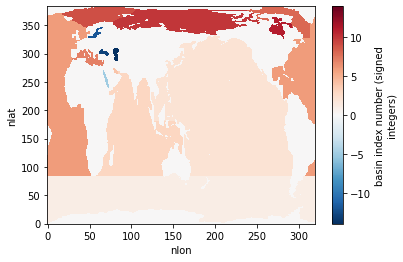

In [16]:
grid.REGION_MASK.plot()

In [17]:
lons = grid.TLONG
lats = grid.TLAT
years = ds.time.values
years

array([1920, 1921, 1922, 1923, 1924, 1925, 1926, 1927, 1928, 1929, 1930,
       1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938, 1939, 1940, 1941,
       1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952,
       1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963,
       1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974,
       1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985,
       1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996,
       1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007,
       2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018,
       2019, 2020, 2021, 2022, 2023, 2024, 2025, 2026, 2027, 2028, 2029,
       2030, 2031, 2032, 2033, 2034, 2035, 2036, 2037, 2038, 2039, 2040,
       2041, 2042, 2043, 2044, 2045, 2046, 2047, 2048, 2049, 2050, 2051,
       2052, 2053, 2054, 2055, 2056, 2057, 2058, 2059, 2060, 2061, 2062,
       2063, 2064, 2065, 2066, 2067, 2068, 2069, 20

### mask out nans in ds

In [18]:
ds = ds.where(grid.REGION_MASK>0)

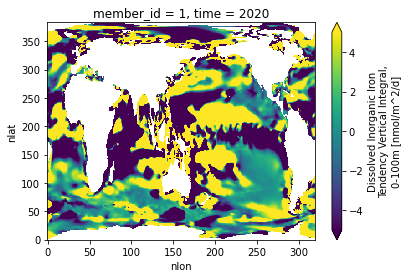

In [19]:
ds.tend_zint_100m_Fe.isel(time=100,member_id=0).plot(vmin=-5,vmax=5)

### get masks for making averages

In [20]:
file = '/glade/work/kristenk/TTE_CESM-LE/masks_1990s_v3.nc'
ds_masks = xr.open_dataset(file,decode_times=False)
ds_masks

<xarray.Dataset>
Dimensions:            (nlat: 384, nlon: 320)
Coordinates:
    TLAT               (nlat, nlon) float64 ...
    TLONG              (nlat, nlon) float64 ...
Dimensions without coordinates: nlat, nlon
Data variables:
    ACC_mask           (nlat, nlon) float64 ...
    SIZ_mask           (nlat, nlon) float64 ...
    marginal_SIZ_mask  (nlat, nlon) float64 ...

### Make timeseries

In [21]:
variables

['Fe_KPP_zint',
 'Bio_Fe_uptake',
 'Fe_FLUX_IN_100m',
 'phys_med_Fe',
 'tend_zint_100m_Fe',
 'IRON_FLUX',
 'Fe_scavenge_zint100m']

### ACC

In [22]:
%%time

ts_ACC = xr.Dataset({v: ds[v] for v in ['time','member_id']})

for v in variables:
    print(v)
    masked = ds[v].where(ds_masks.ACC_mask==1.)
    ts_ACC[v] = esmlab.weighted_mean(masked, weights=grid.TAREA, dim=['nlat', 'nlon']).compute()


Fe_KPP_zint
Bio_Fe_uptake
Fe_FLUX_IN_100m
phys_med_Fe
tend_zint_100m_Fe
IRON_FLUX
Fe_scavenge_zint100m
CPU times: user 1min 45s, sys: 1min 56s, total: 3min 42s
Wall time: 2min 40s


### SIZ

In [23]:
%%time

ts_SIZ = xr.Dataset({v: ds[v] for v in ['time','member_id']})

for v in variables:
    print(v)
    masked = ds[v].where(ds_masks.SIZ_mask==1.)
    ts_SIZ[v] = esmlab.weighted_mean(masked, weights=grid.TAREA, dim=['nlat', 'nlon']).compute()

Fe_KPP_zint
Bio_Fe_uptake
Fe_FLUX_IN_100m
phys_med_Fe
tend_zint_100m_Fe
IRON_FLUX
Fe_scavenge_zint100m
CPU times: user 1min 45s, sys: 1min 55s, total: 3min 41s
Wall time: 2min 42s


In [24]:
ts_ACC_ens_mean = ts_ACC.mean(dim='member_id')
ts_SIZ_ens_mean = ts_SIZ.mean(dim='member_id')

In [25]:
#test = ts_ACC_ens_mean['tend_zint_100m_Fe'] + ts_ACC_ens_mean.Bio_Fe_uptake - ds.IRON_FLUX

In [26]:
#ts_ACC_ens_mean['Bio_Fe_uptake']

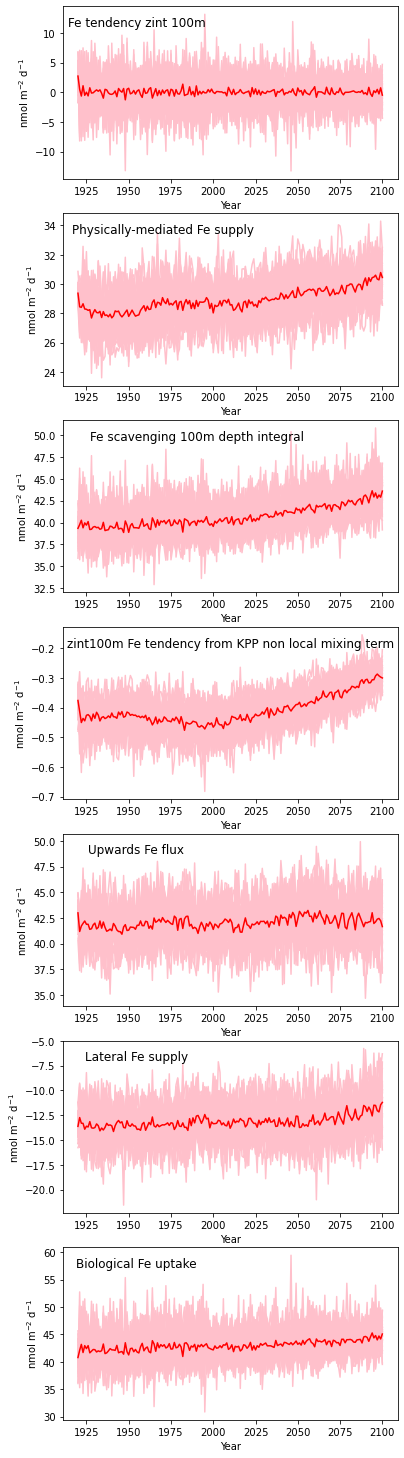

In [27]:
fig, ax = plt.subplots(nrows=7,ncols=1,figsize=(6,26))

ax[0].set_title('Fe tendency zint 100m', x=0.22,y=0.85)
ax[0].set_ylabel('nmol m$^{-2}$ d$^{-1}$')
ax[0].set_xlabel('Year')

for mem in np.arange(0,34,1):

    ax[0].plot(years, 
         ts_ACC['tend_zint_100m_Fe'].isel(member_id=mem), 
         color='pink')

ax[0].plot(years, ts_ACC_ens_mean['tend_zint_100m_Fe'], 
         color='red')

##################################

ax[1].set_title('Physically-mediated Fe supply', x=0.3,y=0.85)
ax[1].set_ylabel('nmol m$^{-2}$ d$^{-1}$')
ax[1].set_xlabel('Year')

for mem in np.arange(0,34,1):

    ax[1].plot(years, 
         ts_ACC['phys_med_Fe'].isel(member_id=mem), 
         color='pink')

ax[1].plot(years, ts_ACC_ens_mean['phys_med_Fe'], 
         color='red')

##################################
ax[2].set_title('Fe scavenging 100m depth integral', x=0.4,y=0.85)
ax[2].set_ylabel('nmol m$^{-2}$ d$^{-1}$')
ax[2].set_xlabel('Year')

for mem in np.arange(0,34,1):

    ax[2].plot(years, 
         ts_ACC['Fe_scavenge_zint100m'].isel(member_id=mem), 
         color='pink')

ax[2].plot(years, ts_ACC_ens_mean['Fe_scavenge_zint100m'], 
         color='red')

##################################

ax[3].set_title('zint100m Fe tendency from KPP non local mixing term', x=0.5,y=0.85)
ax[3].set_ylabel('nmol m$^{-2}$ d$^{-1}$')
ax[3].set_xlabel('Year')

for mem in np.arange(0,34,1):

    ax[3].plot(years, 
         ts_ACC['Fe_KPP_zint'].isel(member_id=mem), 
         color='pink')

ax[3].plot(years, ts_ACC_ens_mean['Fe_KPP_zint'], 
         color='red')


##################################

ax[4].set_title('Upwards Fe flux', x=0.22,y=0.85)
ax[4].set_ylabel('nmol m$^{-2}$ d$^{-1}$')
ax[4].set_xlabel('Year')

for mem in np.arange(0,34,1):

    ax[4].plot(years, 
         ts_ACC['Fe_FLUX_IN_100m'].isel(member_id=mem), 
         color='pink')

ax[4].plot(years, ts_ACC_ens_mean['Fe_FLUX_IN_100m'], 
         color='red')

##################################

ax[5].set_title('Lateral Fe supply', x=0.22,y=0.85)
ax[5].set_ylabel('nmol m$^{-2}$ d$^{-1}$')
ax[5].set_xlabel('Year')
for mem in np.arange(0,34,1):

    ax[5].plot(years, 
         ts_ACC['phys_med_Fe'].isel(member_id=mem) - ts_ACC['Fe_FLUX_IN_100m'].isel(member_id=mem), 
         color='pink')

ax[5].plot(years, ts_ACC_ens_mean['phys_med_Fe'] -ts_ACC_ens_mean['Fe_FLUX_IN_100m'], 
         color='red');

##################################

ax[6].set_title('Biological Fe uptake', x=0.22,y=0.85)
ax[6].set_ylabel('nmol m$^{-2}$ d$^{-1}$')
ax[6].set_xlabel('Year')
for mem in np.arange(0,34,1):

    ax[6].plot(years, 
         ts_ACC['Bio_Fe_uptake'].isel(member_id=mem), 
         color='pink')

ax[6].plot(years, ts_ACC_ens_mean['Bio_Fe_uptake'], 
         color='red');

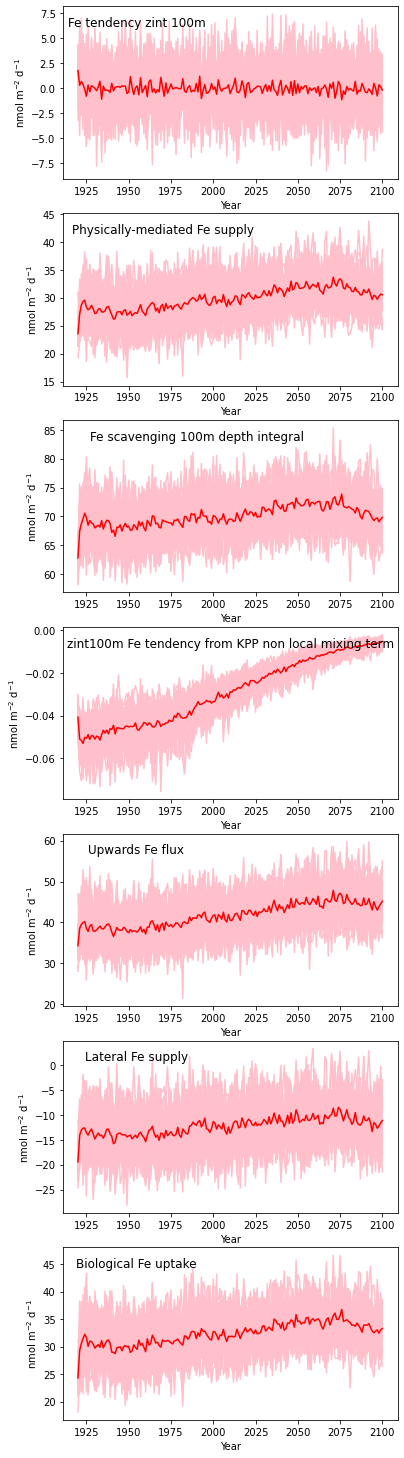

In [28]:
fig, ax = plt.subplots(nrows=7,ncols=1,figsize=(6,26))
#fig.suptitle('SIZ')
ax[0].set_title('Fe tendency zint 100m', x=0.22,y=0.85)
ax[0].set_ylabel('nmol m$^{-2}$ d$^{-1}$')
ax[0].set_xlabel('Year')

for mem in np.arange(0,34,1):

    ax[0].plot(years, 
         ts_SIZ['tend_zint_100m_Fe'].isel(member_id=mem), 
         color='pink')

ax[0].plot(years, ts_SIZ_ens_mean['tend_zint_100m_Fe'], 
         color='red')

##################################

ax[1].set_title('Physically-mediated Fe supply', x=0.3,y=0.85)
ax[1].set_ylabel('nmol m$^{-2}$ d$^{-1}$')
ax[1].set_xlabel('Year')

for mem in np.arange(0,34,1):

    ax[1].plot(years, 
         ts_SIZ['phys_med_Fe'].isel(member_id=mem), 
         color='pink')

ax[1].plot(years, ts_SIZ_ens_mean['phys_med_Fe'], 
         color='red')

##################################
ax[2].set_title('Fe scavenging 100m depth integral', x=0.4,y=0.85)
ax[2].set_ylabel('nmol m$^{-2}$ d$^{-1}$')
ax[2].set_xlabel('Year')

for mem in np.arange(0,34,1):

    ax[2].plot(years, 
         ts_SIZ['Fe_scavenge_zint100m'].isel(member_id=mem), 
         color='pink')

ax[2].plot(years, ts_SIZ_ens_mean['Fe_scavenge_zint100m'], 
         color='red')

##################################

ax[3].set_title('zint100m Fe tendency from KPP non local mixing term', x=0.5,y=0.85)
ax[3].set_ylabel('nmol m$^{-2}$ d$^{-1}$')
ax[3].set_xlabel('Year')

for mem in np.arange(0,34,1):

    ax[3].plot(years, 
         ts_SIZ['Fe_KPP_zint'].isel(member_id=mem), 
         color='pink')

ax[3].plot(years, ts_SIZ_ens_mean['Fe_KPP_zint'], 
         color='red')


##################################

ax[4].set_title('Upwards Fe flux', x=0.22,y=0.85)
ax[4].set_ylabel('nmol m$^{-2}$ d$^{-1}$')
ax[4].set_xlabel('Year')

for mem in np.arange(0,34,1):

    ax[4].plot(years, 
         ts_SIZ['Fe_FLUX_IN_100m'].isel(member_id=mem), 
         color='pink')

ax[4].plot(years, ts_SIZ_ens_mean['Fe_FLUX_IN_100m'], 
         color='red')

##################################

ax[5].set_title('Lateral Fe supply', x=0.22,y=0.85)
ax[5].set_ylabel('nmol m$^{-2}$ d$^{-1}$')
ax[5].set_xlabel('Year')
for mem in np.arange(0,34,1):

    ax[5].plot(years, 
         ts_SIZ['phys_med_Fe'].isel(member_id=mem) - ts_ACC['Fe_FLUX_IN_100m'].isel(member_id=mem), 
         color='pink')

ax[5].plot(years, ts_SIZ_ens_mean['phys_med_Fe'] -ts_ACC_ens_mean['Fe_FLUX_IN_100m'], 
         color='red');

##################################

ax[6].set_title('Biological Fe uptake', x=0.22,y=0.85)
ax[6].set_ylabel('nmol m$^{-2}$ d$^{-1}$')
ax[6].set_xlabel('Year')
for mem in np.arange(0,34,1):

    ax[6].plot(years, 
         ts_SIZ['Bio_Fe_uptake'].isel(member_id=mem), 
         color='pink')

ax[6].plot(years, ts_SIZ_ens_mean['Bio_Fe_uptake'], 
         color='red');